In [1]:
import yaml
import umap

import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor

from cmonge.utils import load_config
from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [3]:
features = "/path/to/functional_and_score_genes.txt"

logger_path = "/path/to/dummy/logger.json"
base_config_path = "/path/to/experiments/cmonge_ood/LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/path/to/experiments/cmonge_ood/LN_True_grad_acc_4_cosine/"
base_fig_save = "/path/to/Figures/transport_UMAPs/cmonge/ood/"

In [8]:
for subset in ["CD8", "CD4"]:
    adata = sc.read_h5ad(f'/path/to/data/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/model"
        config.data.file_path = f"/path/to/data/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/path/to/CAR_variants.txt"
        config.model.embedding.model_dir = "/path/to/embedding/"

        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)
    
        all_meta[["UMAP1", "UMAP2"]] = Y2
    
        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color="grey", s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.title(car)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
        plt.close()

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_96118/2697528537.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-11-13 13:24:46.825 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2024-11-13 13:24:47.384 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:24:47.910 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-11-13 13:24:47.911 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:24:47.912 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:24:47.914 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:24:50.514 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)
41BB-CD28-z


2024-11-13 13:25:20.992 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2024-11-13 13:25:21.586 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:25:21.613 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2024-11-13 13:25:21.614 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:25:21.614 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:25:21.615 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:25:21.734 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(145, 5120)
41BB-CD40-z


2024-11-13 13:25:30.852 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2024-11-13 13:25:31.445 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:25:31.471 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2024-11-13 13:25:31.472 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:25:31.473 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:25:31.474 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:25:31.585 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(94, 5120)
41BB-CTLA4-z


2024-11-13 13:25:40.836 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2024-11-13 13:25:41.424 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:25:41.449 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2024-11-13 13:25:41.450 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:25:41.451 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:25:41.452 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:25:41.573 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
41BB-IL15RA-z


2024-11-13 13:25:50.939 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2024-11-13 13:25:51.516 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:25:51.546 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2024-11-13 13:25:51.547 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:25:51.547 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:25:51.549 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:25:51.660 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(211, 5120)
41BB-NA-z


2024-11-13 13:26:02.033 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2024-11-13 13:26:02.641 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:26:02.666 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2024-11-13 13:26:02.667 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:26:02.668 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:26:02.669 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:26:02.784 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(197, 5120)
CD28-41BB-z


2024-11-13 13:26:12.130 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2024-11-13 13:26:12.754 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:26:12.784 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2024-11-13 13:26:12.786 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:26:12.786 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:26:12.787 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:26:12.904 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(51, 5120)
CD28-CD28-z


2024-11-13 13:26:21.060 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2024-11-13 13:26:21.679 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:26:21.708 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2024-11-13 13:26:21.709 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:26:21.710 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:26:21.711 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:26:21.815 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(168, 5120)
CD28-CD40-z


2024-11-13 13:26:30.978 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2024-11-13 13:26:31.591 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:26:31.627 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2024-11-13 13:26:31.628 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:26:31.629 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:26:31.630 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:26:31.739 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(131, 5120)
CD28-CTLA4-z


2024-11-13 13:26:41.056 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2024-11-13 13:26:42.008 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:26:42.043 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2024-11-13 13:26:42.044 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:26:42.044 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:26:42.046 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:26:42.175 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(87, 5120)
CD28-IL15RA-z


2024-11-13 13:26:52.315 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2024-11-13 13:26:53.457 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:26:53.483 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2024-11-13 13:26:53.484 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:26:53.485 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:26:53.486 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:26:53.596 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(179, 5120)
CD28-NA-z


2024-11-13 13:27:03.075 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2024-11-13 13:27:04.824 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:27:04.855 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2024-11-13 13:27:04.856 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:27:04.856 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:27:04.858 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:27:04.995 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(220, 5120)
CD40-41BB-z


2024-11-13 13:27:21.094 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2024-11-13 13:27:22.170 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:27:22.195 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2024-11-13 13:27:22.196 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:27:22.197 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:27:22.199 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:27:22.310 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(121, 5120)
CD40-CD28-z


2024-11-13 13:27:32.079 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2024-11-13 13:27:34.712 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:27:34.748 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2024-11-13 13:27:34.749 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:27:34.750 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:27:34.751 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:27:34.884 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(193, 5120)
CD40-CD40-z


2024-11-13 13:27:44.458 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2024-11-13 13:27:45.058 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:27:45.084 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2024-11-13 13:27:45.087 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:27:45.088 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:27:45.089 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:27:45.206 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(272, 5120)
CD40-CTLA4-z


2024-11-13 13:27:56.212 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2024-11-13 13:27:57.748 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:27:57.779 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2024-11-13 13:27:57.780 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:27:57.780 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:27:57.781 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:27:57.906 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2024-11-13 13:28:07.329 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2024-11-13 13:28:08.999 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:28:09.024 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2024-11-13 13:28:09.026 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:28:09.026 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:28:09.027 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:28:09.139 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(138, 5120)
CD40-NA-z


2024-11-13 13:28:18.658 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2024-11-13 13:28:21.810 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:28:21.843 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2024-11-13 13:28:21.844 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:28:21.845 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:28:21.847 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:28:21.988 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(251, 5120)
CTLA4-41BB-z


2024-11-13 13:28:34.318 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2024-11-13 13:28:34.842 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:28:34.868 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2024-11-13 13:28:34.869 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:28:34.870 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:28:34.871 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:28:34.985 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(34, 5120)
CTLA4-CD28-z


2024-11-13 13:28:41.739 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2024-11-13 13:28:42.244 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:28:42.269 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2024-11-13 13:28:42.270 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:28:42.271 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:28:42.272 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:28:42.390 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)
CTLA4-CD40-z


2024-11-13 13:28:50.969 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2024-11-13 13:28:51.457 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:28:51.481 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2024-11-13 13:28:51.482 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:28:51.484 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:28:51.485 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:28:51.593 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2024-11-13 13:28:59.256 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2024-11-13 13:28:59.755 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:28:59.779 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2024-11-13 13:28:59.782 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:28:59.783 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:28:59.783 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:28:59.894 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(24, 5120)
CTLA4-IL15RA-z


2024-11-13 13:29:07.816 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2024-11-13 13:29:08.323 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:29:08.349 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2024-11-13 13:29:08.350 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:29:08.352 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:29:08.353 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:29:08.480 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(46, 5120)
CTLA4-NA-z


2024-11-13 13:29:16.605 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2024-11-13 13:29:17.106 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:29:17.129 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2024-11-13 13:29:17.131 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:29:17.131 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:29:17.132 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:29:17.243 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2024-11-13 13:29:24.621 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2024-11-13 13:29:25.106 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:29:25.130 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2024-11-13 13:29:25.131 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:29:25.132 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:29:25.133 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:29:25.239 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(241, 5120)
IL15RA-CD28-z


2024-11-13 13:29:33.118 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2024-11-13 13:29:33.721 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:29:33.752 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-11-13 13:29:33.753 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:29:33.753 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:29:33.754 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:29:33.855 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2024-11-13 13:29:43.727 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2024-11-13 13:29:44.349 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:29:44.385 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2024-11-13 13:29:44.386 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:29:44.386 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:29:44.388 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:29:44.495 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(284, 5120)
IL15RA-CTLA4-z


2024-11-13 13:29:59.014 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2024-11-13 13:29:59.618 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:29:59.647 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2024-11-13 13:29:59.648 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:29:59.649 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:29:59.650 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:29:59.781 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(234, 5120)
IL15RA-IL15RA-z


2024-11-13 13:30:19.235 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2024-11-13 13:30:19.823 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:30:19.856 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2024-11-13 13:30:19.857 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:30:19.858 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:30:19.859 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:30:19.961 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(122, 5120)
IL15RA-NA-z


2024-11-13 13:30:36.855 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2024-11-13 13:30:37.503 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:30:37.531 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2024-11-13 13:30:37.532 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-11-13 13:30:37.533 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:30:37.535 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:30:37.638 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(231, 5120)


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_96118/2697528537.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-11-13 13:31:24.172 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2024-11-13 13:31:24.809 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:31:24.844 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-11-13 13:31:24.845 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:31:24.846 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:31:24.847 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:31:24.991 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD28-z


2024-11-13 13:31:46.826 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2024-11-13 13:31:47.739 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:31:47.763 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2024-11-13 13:31:47.764 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:31:47.765 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:31:47.766 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:31:47.875 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD40-z


2024-11-13 13:32:03.336 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2024-11-13 13:32:04.021 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:32:04.045 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2024-11-13 13:32:04.046 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:32:04.047 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:32:04.049 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:32:04.157 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2024-11-13 13:32:24.156 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2024-11-13 13:32:25.380 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:32:25.403 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2024-11-13 13:32:25.404 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:32:25.404 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:32:25.405 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:32:25.515 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(62, 5120)
41BB-IL15RA-z


2024-11-13 13:32:39.031 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2024-11-13 13:32:40.741 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:32:40.774 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2024-11-13 13:32:40.775 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:32:40.776 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:32:40.777 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:32:40.924 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-NA-z


2024-11-13 13:32:50.475 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2024-11-13 13:32:52.715 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:32:52.739 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2024-11-13 13:32:52.740 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:32:52.741 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:32:52.742 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:32:53.887 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-41BB-z


2024-11-13 13:33:04.236 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2024-11-13 13:33:06.168 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:33:06.192 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2024-11-13 13:33:06.193 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:33:06.194 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:33:06.195 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:33:06.307 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(43, 5120)
CD28-CD28-z


2024-11-13 13:33:16.595 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2024-11-13 13:33:18.732 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:33:18.764 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2024-11-13 13:33:18.765 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:33:18.766 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:33:18.768 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:33:18.910 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CD40-z


2024-11-13 13:33:28.783 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2024-11-13 13:33:30.362 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:33:30.387 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2024-11-13 13:33:30.388 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:33:30.389 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:33:30.390 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:33:30.508 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2024-11-13 13:33:40.203 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2024-11-13 13:33:40.748 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:33:40.772 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2024-11-13 13:33:40.774 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:33:40.775 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:33:40.776 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:33:40.896 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2024-11-13 13:33:48.454 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2024-11-13 13:33:48.984 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:33:49.009 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2024-11-13 13:33:49.010 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:33:49.010 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:33:49.012 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:33:49.134 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-NA-z


2024-11-13 13:33:57.527 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2024-11-13 13:33:58.072 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:33:58.096 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2024-11-13 13:33:58.097 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:33:58.098 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:33:58.099 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:33:58.227 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-41BB-z


2024-11-13 13:34:05.541 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2024-11-13 13:34:06.078 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:34:06.105 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2024-11-13 13:34:06.106 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:34:06.107 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:34:06.108 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:34:06.226 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-CD28-z


2024-11-13 13:34:13.599 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2024-11-13 13:34:14.128 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:34:14.152 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2024-11-13 13:34:14.153 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:34:14.154 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:34:14.155 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:34:14.264 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(147, 5120)
CD40-CD40-z


2024-11-13 13:34:23.135 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2024-11-13 13:34:23.656 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:34:23.679 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2024-11-13 13:34:23.680 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:34:23.680 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:34:23.681 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:34:23.788 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)
CD40-CTLA4-z


2024-11-13 13:34:31.694 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2024-11-13 13:34:32.225 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:34:32.251 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2024-11-13 13:34:32.252 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:34:32.253 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:34:32.254 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:34:32.358 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)
CD40-IL15RA-z


2024-11-13 13:34:40.574 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2024-11-13 13:34:41.183 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:34:41.212 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2024-11-13 13:34:41.213 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:34:41.213 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:34:41.214 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:34:41.342 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-NA-z


2024-11-13 13:34:54.505 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2024-11-13 13:34:55.179 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:34:55.208 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2024-11-13 13:34:55.210 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:34:55.210 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:34:55.211 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:34:55.322 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2024-11-13 13:35:04.737 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2024-11-13 13:35:05.392 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:35:05.425 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2024-11-13 13:35:05.426 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:35:05.428 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:35:05.430 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:35:05.557 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(47, 5120)
CTLA4-CD28-z


2024-11-13 13:35:15.741 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2024-11-13 13:35:16.412 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:35:16.441 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2024-11-13 13:35:16.442 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:35:16.443 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:35:16.444 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:35:16.558 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(113, 5120)
CTLA4-CD40-z


2024-11-13 13:35:26.164 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2024-11-13 13:35:26.792 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:35:26.817 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2024-11-13 13:35:26.818 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:35:26.819 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:35:26.820 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:35:26.952 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(40, 5120)
CTLA4-CTLA4-z


2024-11-13 13:35:35.970 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2024-11-13 13:35:36.616 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:35:36.647 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2024-11-13 13:35:36.648 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:35:36.649 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:35:36.650 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:35:36.765 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2024-11-13 13:35:45.017 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2024-11-13 13:35:46.262 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:35:46.286 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2024-11-13 13:35:46.287 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:35:46.288 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:35:46.289 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:35:46.393 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(38, 5120)
CTLA4-NA-z


2024-11-13 13:35:56.693 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2024-11-13 13:35:57.411 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:35:57.435 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2024-11-13 13:35:57.437 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:35:57.437 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:35:57.438 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:35:57.551 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(42, 5120)
IL15RA-41BB-z


2024-11-13 13:36:10.022 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2024-11-13 13:36:11.659 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:36:11.693 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2024-11-13 13:36:11.694 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:36:11.695 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:36:11.696 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:36:11.844 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2024-11-13 13:36:21.740 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2024-11-13 13:36:22.512 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:36:22.557 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2024-11-13 13:36:22.558 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:36:22.559 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:36:22.560 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:36:22.688 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2024-11-13 13:36:32.950 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2024-11-13 13:36:34.880 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:36:34.906 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2024-11-13 13:36:34.907 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:36:34.908 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:36:34.909 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:36:35.030 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2024-11-13 13:36:46.217 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2024-11-13 13:36:48.842 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:36:48.866 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2024-11-13 13:36:48.867 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:36:48.867 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:36:48.869 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:36:48.982 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(91, 5120)
IL15RA-IL15RA-z


2024-11-13 13:37:01.451 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2024-11-13 13:37:05.944 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:37:05.976 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2024-11-13 13:37:05.977 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:37:05.978 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:37:05.979 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:37:06.127 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2024-11-13 13:37:13.818 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2024-11-13 13:37:14.373 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:37:14.399 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2024-11-13 13:37:14.400 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:37:14.401 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:37:14.402 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:37:14.508 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_94450/3789428869.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-11-13 13:44:54.411 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2024-11-13 13:44:54.922 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:44:55.408 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-11-13 13:44:55.409 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:44:55.410 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:44:55.411 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:44:57.924 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD28-z


2024-11-13 13:45:20.534 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2024-11-13 13:45:21.052 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:21.076 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2024-11-13 13:45:21.077 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:21.078 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:21.079 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:21.182 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD40-z


2024-11-13 13:45:24.516 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2024-11-13 13:45:25.030 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:25.054 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2024-11-13 13:45:25.055 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:25.056 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:25.057 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:25.163 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2024-11-13 13:45:28.473 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2024-11-13 13:45:29.024 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:29.048 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2024-11-13 13:45:29.049 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:29.050 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:29.051 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:29.159 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(62, 5120)
41BB-IL15RA-z


2024-11-13 13:45:33.334 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2024-11-13 13:45:33.876 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:33.899 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2024-11-13 13:45:33.900 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:33.901 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:33.902 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:34.008 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-NA-z


2024-11-13 13:45:37.324 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2024-11-13 13:45:37.843 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:37.866 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2024-11-13 13:45:37.867 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:37.868 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:37.869 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:37.973 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-41BB-z


2024-11-13 13:45:41.556 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2024-11-13 13:45:42.103 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:42.127 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2024-11-13 13:45:42.128 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:42.129 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:42.130 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:42.234 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(43, 5120)
CD28-CD28-z


2024-11-13 13:45:46.085 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2024-11-13 13:45:46.611 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:46.635 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2024-11-13 13:45:46.636 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:46.637 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:46.638 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:46.747 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CD40-z


2024-11-13 13:45:50.371 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2024-11-13 13:45:50.912 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:50.936 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2024-11-13 13:45:50.937 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:50.937 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:50.938 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:51.046 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2024-11-13 13:45:54.588 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2024-11-13 13:45:55.115 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:45:55.138 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2024-11-13 13:45:55.139 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:45:55.140 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:45:55.141 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:45:55.243 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2024-11-13 13:45:59.903 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2024-11-13 13:46:00.873 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:00.910 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2024-11-13 13:46:00.911 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:00.913 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:00.915 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:01.057 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-NA-z


2024-11-13 13:46:06.316 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2024-11-13 13:46:06.960 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:06.984 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2024-11-13 13:46:06.985 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:06.986 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:06.987 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:07.100 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-41BB-z


2024-11-13 13:46:17.123 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2024-11-13 13:46:18.611 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:18.640 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2024-11-13 13:46:18.641 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:18.642 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:18.643 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:18.773 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-CD28-z


2024-11-13 13:46:24.955 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2024-11-13 13:46:25.676 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:25.704 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2024-11-13 13:46:25.705 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:25.706 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:25.707 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:25.818 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(147, 5120)
CD40-CD40-z


2024-11-13 13:46:32.000 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2024-11-13 13:46:32.675 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:32.698 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2024-11-13 13:46:32.699 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:32.700 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:32.701 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:32.805 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)
CD40-CTLA4-z


2024-11-13 13:46:38.786 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2024-11-13 13:46:40.433 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:40.457 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2024-11-13 13:46:40.458 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:40.459 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:40.460 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:40.582 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)
CD40-IL15RA-z


2024-11-13 13:46:46.394 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2024-11-13 13:46:47.150 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:47.179 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2024-11-13 13:46:47.180 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:47.181 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:47.182 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:47.432 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-NA-z


2024-11-13 13:46:52.742 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2024-11-13 13:46:53.869 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:46:53.901 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2024-11-13 13:46:53.902 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:46:53.903 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:46:53.904 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:46:54.044 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2024-11-13 13:46:58.752 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2024-11-13 13:46:59.979 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:00.003 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2024-11-13 13:47:00.004 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:00.005 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:00.006 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:00.118 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(47, 5120)
CTLA4-CD28-z


2024-11-13 13:47:04.746 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2024-11-13 13:47:05.362 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:05.385 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2024-11-13 13:47:05.386 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:05.387 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:05.388 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:05.490 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(113, 5120)
CTLA4-CD40-z


2024-11-13 13:47:11.153 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2024-11-13 13:47:11.794 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:11.817 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2024-11-13 13:47:11.819 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:11.819 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:11.820 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:11.932 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(40, 5120)
CTLA4-CTLA4-z


2024-11-13 13:47:17.071 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2024-11-13 13:47:18.298 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:18.324 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2024-11-13 13:47:18.325 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:18.326 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:18.327 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:18.439 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2024-11-13 13:47:23.930 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2024-11-13 13:47:24.585 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:24.615 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2024-11-13 13:47:24.617 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:24.617 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:24.619 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:24.771 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(38, 5120)
CTLA4-NA-z


2024-11-13 13:47:30.211 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2024-11-13 13:47:31.138 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:31.160 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2024-11-13 13:47:31.161 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:31.162 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:31.163 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:31.276 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(42, 5120)
IL15RA-41BB-z


2024-11-13 13:47:36.647 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2024-11-13 13:47:38.232 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:38.259 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2024-11-13 13:47:38.260 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:38.261 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:38.262 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:38.379 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2024-11-13 13:47:43.642 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2024-11-13 13:47:44.303 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:44.334 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2024-11-13 13:47:44.335 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:44.336 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:44.337 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:44.454 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2024-11-13 13:47:49.302 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2024-11-13 13:47:51.019 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:51.046 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2024-11-13 13:47:51.047 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:51.048 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:51.049 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:51.164 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2024-11-13 13:47:55.637 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2024-11-13 13:47:56.824 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:47:56.847 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2024-11-13 13:47:56.848 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:47:56.849 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:47:56.850 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:47:56.957 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(91, 5120)
IL15RA-IL15RA-z


2024-11-13 13:48:02.450 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2024-11-13 13:48:03.755 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:48:03.781 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2024-11-13 13:48:03.782 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:48:03.783 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:48:03.784 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:48:03.907 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2024-11-13 13:48:08.418 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2024-11-13 13:48:10.028 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-11-13 13:48:10.060 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2024-11-13 13:48:10.060 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-11-13 13:48:10.061 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-11-13 13:48:10.063 | INFO     | cmonge.trainers.ot_trainer:__init__:39 - JAX uses cpu for trianing.
2024-11-13 13:48:10.208 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:136 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)


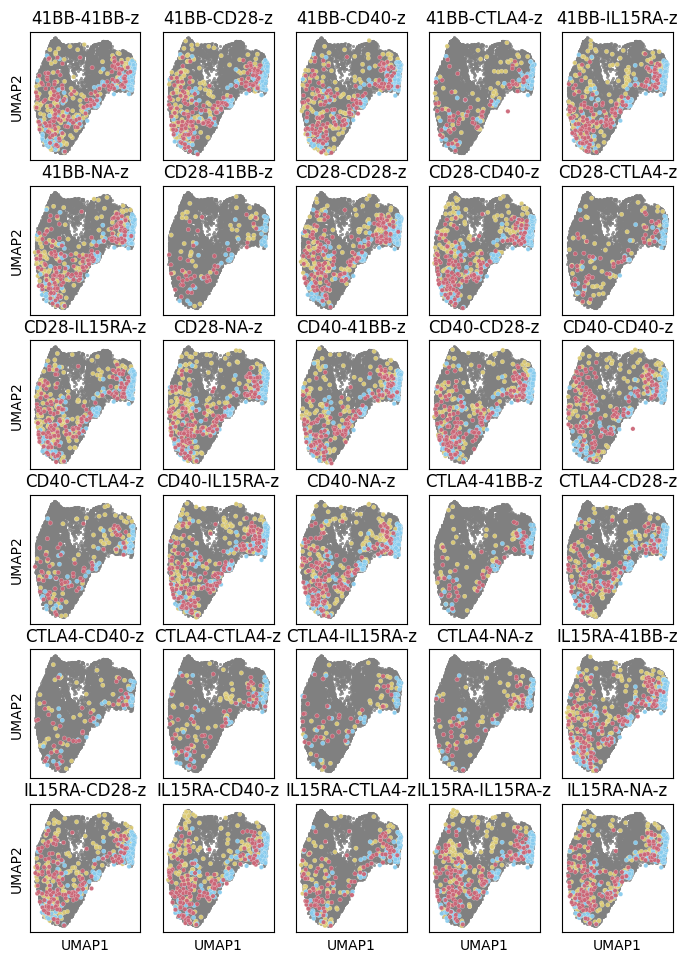

In [4]:
for subset in ["CD8", "CD4"]:
    adata = sc.read_h5ad(f'/path/to/data/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    fig, axes = plt.subplots(nrows=6,ncols=5, sharex=True, sharey=True, figsize=(8.3, 11.7))
    flat_axes = axes.flatten()
    i =0

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/model"
        config.data.file_path = f"/path/to/data/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/path/to/CAR_variants.txt"
        config.model.embedding.model_dir = "/path/to/embedding/"

        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color="grey", s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
        flat_axes[i].get_legend().remove()
        flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        flat_axes[i].set_title(car)
        i+=1
    plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
    plt.show()